/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 0.1704
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.3515
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0965 
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1076 
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0701  
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0510 
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0293    
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0284
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0317
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0361 
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0335
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0334
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0271
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0144
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0214
Epoch 16/

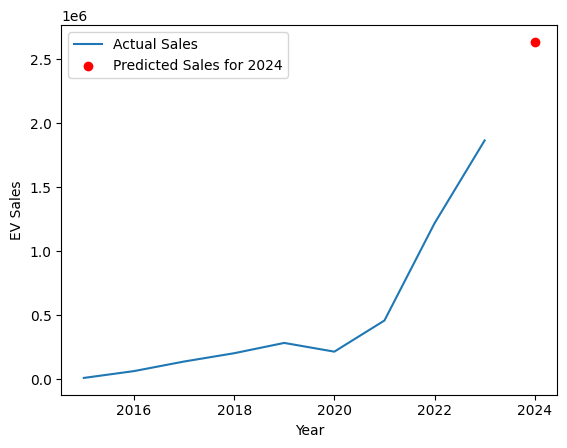

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

data = {
    'Year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'EV': [8392,61717,136578,201557,282233,213910,457457,1218225,1866241]
}
df = pd.DataFrame(data)

# Step 1: Preprocess the data
df['Scaled_Year'] = MinMaxScaler().fit_transform(df[['Year']])

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['EV']])

def create_sequences(data, feature_data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        seq_x = data[i:i+sequence_length]
        seq_feature = feature_data[i:i+sequence_length]  # Feature data matching the sequence length
        seq_x = np.hstack((seq_x, seq_feature))  # Concatenate along the feature axis
        X.append(seq_x)
        y.append(data[i+sequence_length])  # Predict next EV sales value
    return np.array(X), np.array(y)

sequence_length = 5  # Sequence length
X, y = create_sequences(scaled_data, df[['Scaled_Year']].values, sequence_length)

X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Step 2: Build the improved LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))  # Adding dropout to prevent overfitting
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Step 3: Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X, y, epochs=200, batch_size=1, callbacks=[early_stopping])

# Step 4: Predict the future EV sales (for 2024)
last_sequence = scaled_data[-sequence_length:]
last_year_sequence = df[['Scaled_Year']].values[-sequence_length:]  # Year feature sequence

last_sequence = np.hstack((last_sequence, last_year_sequence))

last_sequence = np.reshape(last_sequence, (1, sequence_length, X.shape[2]))

predicted_value = model.predict(last_sequence)
predicted_value = scaler.inverse_transform(predicted_value)  # Rescale back to original scale

print(f"Predicted EV sales for 2024: {predicted_value[0][0]}")

plt.plot(df['Year'], df['EV'], label='Actual Sales')
plt.scatter(2024, predicted_value[0][0], color='red', label='Predicted Sales for 2024')
plt.xlabel('Year')
plt.ylabel('EV Sales')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


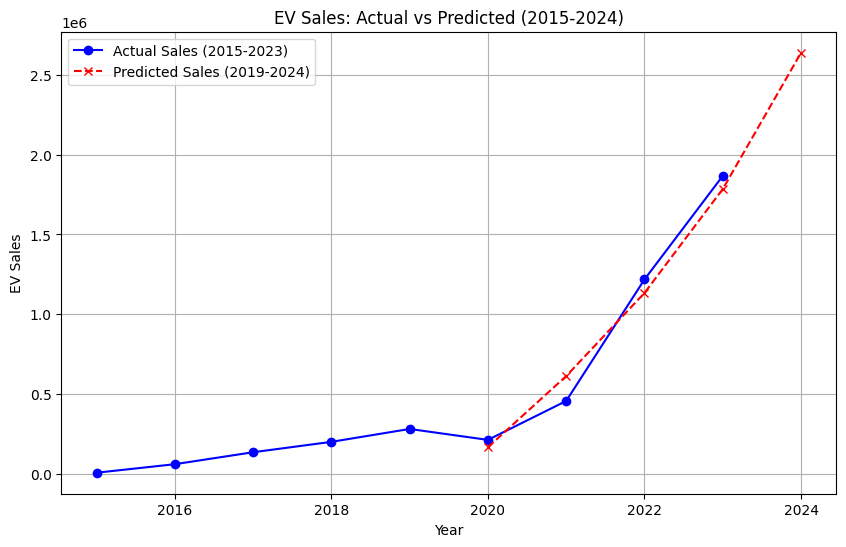

In [ ]:
predicted_ev_sales = []

for i in range(sequence_length, len(scaled_data) + 1):

    if i == len(scaled_data):
        seq_x = scaled_data[-sequence_length:]
        seq_feature = df[['Scaled_Year']].values[-sequence_length:]
    else:
        seq_x = scaled_data[i - sequence_length:i]
        seq_feature = df[['Scaled_Year']].values[i - sequence_length:i]

    seq_x = np.hstack((seq_x, seq_feature))
    seq_x = np.reshape(seq_x, (1, sequence_length, X.shape[2]))

    predicted_value = model.predict(seq_x)
    predicted_value = scaler.inverse_transform(predicted_value)  # Rescale back to original scale
    predicted_ev_sales.append(predicted_value[0][0])

ev_years = df['Year'].values
ev_years_with_2024 = np.append(ev_years, 2024)

plt.figure(figsize=(10, 6))

plt.plot(ev_years, df['EV'], color='blue', marker='o', label='Actual Sales (2015-2023)')

plt.plot(ev_years_with_2024[-len(predicted_ev_sales):], predicted_ev_sales, color='red', linestyle='--', marker='x', label='Predicted Sales (2019-2024)')

plt.title('EV Sales: Actual vs Predicted (2015-2024)')
plt.xlabel('Year')
plt.ylabel('EV Sales')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0484
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0675 
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0260 
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0240     
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0348 
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0232     
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0443 
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0307 
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0345  
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0208 
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0119 
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0335 
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0146 
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042     
Epoch 16/200
4/4 ━━

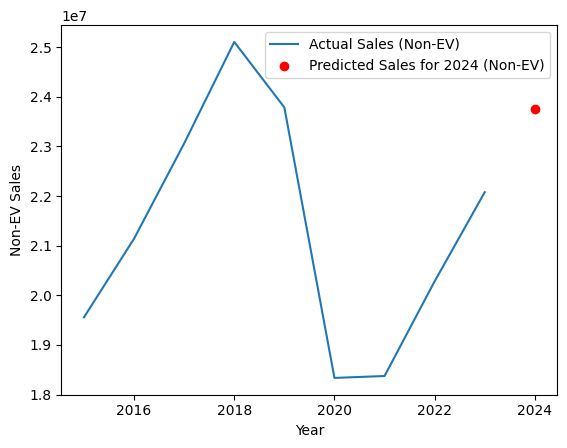

In [ ]:
non_ev_data = {
    'Year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'Non_EV': [19555665,21139396,23058193,25103612,23784112,18334382,18372878,20281307,22076742]
}
non_ev_df = pd.DataFrame(non_ev_data)

# Step 1: Preprocess the data for Non-EV
non_ev_df['Scaled_Year'] = MinMaxScaler().fit_transform(non_ev_df[['Year']])

# Scaling the Non-EV sales data
non_ev_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_non_ev_data = non_ev_scaler.fit_transform(non_ev_df[['Non_EV']])

def create_non_ev_sequences(data, feature_data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        seq_x = data[i:i+sequence_length]
        seq_feature = feature_data[i:i+sequence_length]
        seq_x = np.hstack((seq_x, seq_feature))
        X.append(seq_x)
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

non_ev_sequence_length = 5
X_non_ev, y_non_ev = create_non_ev_sequences(scaled_non_ev_data, non_ev_df[['Scaled_Year']].values, non_ev_sequence_length)

X_non_ev = np.reshape(X_non_ev, (X_non_ev.shape[0], X_non_ev.shape[1], X_non_ev.shape[2]))

# Step 2: Build the improved LSTM model for Non-EV
non_ev_model = Sequential()
non_ev_model.add(LSTM(units=100, return_sequences=True, input_shape=(X_non_ev.shape[1], X_non_ev.shape[2])))
non_ev_model.add(Dropout(0.2))
non_ev_model.add(LSTM(units=100))
non_ev_model.add(Dropout(0.2))
non_ev_model.add(Dense(units=1))

non_ev_model.compile(optimizer='adam', loss='mean_squared_error')

# Step 3: Early stopping to avoid overfitting
non_ev_early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

non_ev_model.fit(X_non_ev, y_non_ev, epochs=200, batch_size=1, callbacks=[non_ev_early_stopping])

# Step 4: Predict the future Non-EV sales (for 2024)
last_non_ev_sequence = scaled_non_ev_data[-non_ev_sequence_length:]
last_non_ev_year_sequence = non_ev_df[['Scaled_Year']].values[-non_ev_sequence_length:]

last_non_ev_sequence = np.hstack((last_non_ev_sequence, last_non_ev_year_sequence))

last_non_ev_sequence = np.reshape(last_non_ev_sequence, (1, non_ev_sequence_length, X_non_ev.shape[2]))

predicted_non_ev_value = non_ev_model.predict(last_non_ev_sequence)
predicted_non_ev_value = non_ev_scaler.inverse_transform(predicted_non_ev_value)

print(f"Predicted Non-EV sales for 2024: {predicted_non_ev_value[0][0]}")

plt.plot(non_ev_df['Year'], non_ev_df['Non_EV'], label='Actual Sales (Non-EV)')
plt.scatter(2024, predicted_non_ev_value[0][0], color='red', label='Predicted Sales for 2024 (Non-EV)')
plt.xlabel('Year')
plt.ylabel('Non-EV Sales')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


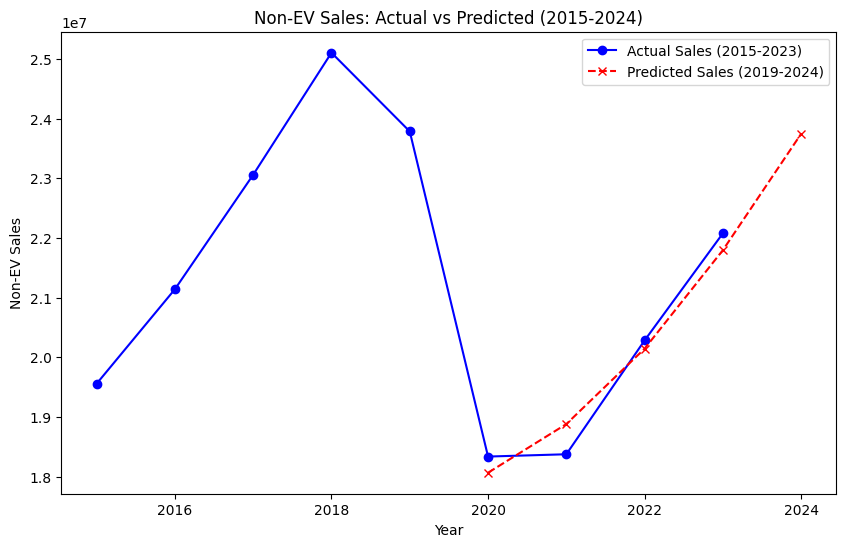

In [ ]:
predicted_non_ev_sales = []

for i in range(non_ev_sequence_length, len(scaled_non_ev_data) + 1):

    if i == len(scaled_non_ev_data):
        seq_x = scaled_non_ev_data[-non_ev_sequence_length:]
        seq_feature = non_ev_df[['Scaled_Year']].values[-non_ev_sequence_length:]
    else:
        seq_x = scaled_non_ev_data[i-non_ev_sequence_length:i]
        seq_feature = non_ev_df[['Scaled_Year']].values[i-non_ev_sequence_length:i]

    seq_x = np.hstack((seq_x, seq_feature))
    seq_x = np.reshape(seq_x, (1, non_ev_sequence_length, X_non_ev.shape[2]))

    predicted_value = non_ev_model.predict(seq_x)
    predicted_value = non_ev_scaler.inverse_transform(predicted_value)
    predicted_non_ev_sales.append(predicted_value[0][0])

years = non_ev_df['Year'].values
years_with_2024 = np.append(years, 2024)

plt.figure(figsize=(10, 6))
plt.plot(years, non_ev_df['Non_EV'], color='blue', marker='o', label='Actual Sales (2015-2023)')

plt.plot(years_with_2024[-len(predicted_non_ev_sales):], predicted_non_ev_sales, color='red', linestyle='--', marker='x', label='Predicted Sales (2019-2024)') # Use only the years for which you have predictions

plt.title('Non-EV Sales: Actual vs Predicted (2015-2024)')
plt.xlabel('Year')
plt.ylabel('Non-EV Sales') # Include the ylabel
plt.legend()
plt.show()